# Space

In [1]:
import os
import sys 
import logging
import random
import pandas as pd 
from pprint import pprint 
from IPython.display import display, HTML

# WorkSpace
KEY = 'WorkSpace'; WORKSPACE_PATH = os.getcwd().split(KEY)[0] + KEY; print(WORKSPACE_PATH)
os.chdir(WORKSPACE_PATH)
sys.path.append(WORKSPACE_PATH)

# Pipeline Space
from proj_space import SPACE
SPACE['WORKSPACE_PATH'] = WORKSPACE_PATH
sys.path.append(SPACE['CODE_FN'])
pprint(SPACE)

# Available Packages
import argparse
import datasets
import pandas as pd
from datetime import datetime 

from recfldtkn.ckpd_obs import Ckpd_ObservationS
from recfldtkn.configfn import load_cohort_args
from recfldtkn.loadtools import update_args_to_list

logger = logging.getLogger(__name__)
recfldtkn_config_path = os.path.join(SPACE['CODE_RFT'], 'config_recfldtkn/')

/Users/floydluo/Library/CloudStorage/OneDrive-DRFIRST.COM,INC/Documents - DrFirst-JHU Collaboration Center/DrFirst-Project/2024-DrFirst-v2-SPACE/_DrFirst-AI-EduRxPred-WorkSpace
{'CODE_FN': '../pipeline',
 'CODE_RFT': '../pipeline',
 'DATA_CaseFeat': '../_Data/3-Data_CaseFeat',
 'DATA_CaseObs': '../_Data/2-Data_CaseObs',
 'DATA_CaseSet': '../_Data/4-Data_CaseSet',
 'DATA_EXTERNAL': '../external',
 'DATA_RAW': '../_Data/0-Data_Raw',
 'DATA_RFT': '../_Data/1-Data_RFT',
 'DATA_TASK': 'Data_EduRxPred',
 'MODEL_TASK': 'Model_EduRxPred',
 'TaskName': 'EduRxPred',
 'WORKSPACE_PATH': '/Users/floydluo/Library/CloudStorage/OneDrive-DRFIRST.COM,INC/Documents '
                   '- DrFirst-JHU Collaboration '
                   'Center/DrFirst-Project/2024-DrFirst-v2-SPACE/_DrFirst-AI-EduRxPred-WorkSpace'}


In [2]:
import datasets
from recfldtkn.loadtools import load_ds_rec_and_info
from recfldtkn.configfn import load_cohort_args, load_record_args

base_config = load_cohort_args(recfldtkn_config_path, SPACE)
print(base_config)

{'CohortInfo': {'RawData2023Nov_Trulicity': {'cohort_label': 1, 'cohort_name': 'RawData2023Nov_Trulicity', 'FolderPath': '../_Data/0-Data_Raw/2023_11_30_30days_Trulicity'}}, 'RawRootID': 'patient_id_encoded', 'RootID': 'PID', 'RecName': 'PRawRecNum', 'recattr_pyfolder': '../pipeline/fn_recattr/', 'fldtkn_pyfolder': '../pipeline/fn_fldtkn/', 'humanrec_pyfolder': '../pipeline/fn_humanrec/', 'inference_pyfolder': '../pipeline/fn_inference/', 'trigger_pyfolder': '../pipeline/fn_trigger/', 'RecName_Sequence': ['P', 'PInv', 'Rx', 'EgmAuthen', 'EgmCallPharm', 'EgmClick', 'EgmCopay', 'EgmEdu', 'EgmRmd'], 'RecName_to_PrtRecName': {'P': 'None', 'PInv': 'P', 'Rx': 'PInv', 'EgmAuthen': 'PInv', 'EgmCallPharm': 'PInv', 'EgmClick': 'PInv', 'EgmCopay': 'Rx', 'EgmEdu': 'Rx', 'EgmRmd': 'Rx'}, 'RecName_to_RFT_GROUP_SIZE': {'Default': 5000}, 'RecName_to_RFT_idx_group_size': {'Default': 10000}, 'RecName_to_RFT_usebucket': {'Default': False}, 'RootIDLength': 6, 'recfldtkn_config_path': '../pipeline/config_r

In [3]:
from recfldtkn.loadtools import fetch_entry_tools

# Step 1: DF Learning Case with Tags/Split

In [4]:
use_learning = True 
use_inference = not use_learning

######################################
TriggerCaseMethod = 'TrulicityRx'
cohort_label_list = [1]
Trigger2LearningMethods = [
    {'op':'Tag',    'Name': 'TagPttBasicInfo', 'type': 'learning-only'},
    {'op':'Filter', 'Name': 'FilterBasicPRx',  'type': 'learning-only'},
]
######################################


##############
RANDOM_SEED = 42
downsample_ratio = 1 # 1 (don't drop any case), 0.1 (drop 90% of cases of one patient).
out_ratio = 0
test_ratio = '2023.10.15'#  'tail0.1'
valid_ratio = 0.1 
SplitMethod = f'rs{RANDOM_SEED}-ds{downsample_ratio}-out{out_ratio}ts{test_ratio}vd{valid_ratio}' 
##############

In [5]:
from recfldtkn.pipeline_model import get_Trigger_Cases, convert_TriggerCases_to_LearningCases
from recfldtkn.loadtools import fetch_trigger_tools    

Trigger_Tools = fetch_trigger_tools(TriggerCaseMethod, SPACE)
RecName_to_dsRec = {}
RecName_to_dsRecInfo = {}

# dsRec comes from 
# (1) cohort_label_list, base_config, SPACE
# (2) RecName_to_dsRec, RecName_to_dsRecInfo
df_case = get_Trigger_Cases(TriggerCaseMethod,
                            cohort_label_list,
                            base_config, SPACE, 
                            RecName_to_dsRec, 
                            RecName_to_dsRecInfo)

                            
df_case = convert_TriggerCases_to_LearningCases(df_case, 
                                                cohort_label_list,
                                                Trigger2LearningMethods, 
                                                base_config, 
                                                use_inference)


logger.info(f'After: {df_case.shape}')

[INFO:2024-03-03 02:39:59,688:(pipeline_model.py@84 recfldtkn.pipeline_model)]: CaseTag: TagPttBasicInfo
[INFO:2024-03-03 02:39:59,741:(pipeline_model.py@99 recfldtkn.pipeline_model)]: CaseFilter: FilterBasicPRx
[INFO:2024-03-03 02:39:59,743:(pipeline_model.py@103 recfldtkn.pipeline_model)]: Before Filter: (101006, 10)
[INFO:2024-03-03 02:39:59,787:(pipeline_model.py@105 recfldtkn.pipeline_model)]: After Filter: (98762, 10)
[INFO:2024-03-03 02:39:59,789:(1062184578.py@25 __main__)]: After: (98762, 10)


In [6]:
from recfldtkn.pipeline_model import assign_caseSplitTag_to_dsCaseLearning


df_case = assign_caseSplitTag_to_dsCaseLearning(df_case, 
                                                RANDOM_SEED, 
                                                downsample_ratio, out_ratio, 
                                                test_ratio, valid_ratio)
df_case 

,PID,ObsDT,PInvID,RxID,DT,drug_name,patient_gender,patient_age_bucket,patient_zipcode_3,cohort,Out,In,Test,Valid,Train
0,1015641,2023-03-17 15:20:48.692,1015641-000,1015641-000-000,2023-03-17 15:20:48.692,Trulicity,F,51-60,350.0,C1,False,True,False,False,True
1,1026251,2023-09-20 23:28:54.737,1026251-000,1026251-000-000,2023-09-20 23:28:54.737,Trulicity,F,31-40,606.0,C1,False,True,False,False,True
2,1001401,2023-10-28 00:58:29.134,1001401-031,1001401-031-001,2023-10-28 00:58:29.134,Trulicity,F,81+,856.0,C1,False,True,True,False,False
3,1019852,2023-09-01 21:12:22.742,1019852-020,1019852-020-000,2023-09-01 21:12:22.742,Trulicity,M,51-60,900.0,C1,False,True,False,False,True
4,1045643,2023-08-23 19:38:28.001,1045643-013,1045643-013-000,2023-08-23 19:38:28.001,Trulicity,F,41-50,741.0,C1,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98757,1027142,2023-10-03 14:14:36.760,1027142-004,1027142-004-000,2023-10-03 14:14:36.760,Trulicity,F,71-80,147.0,C1,False,True,False,False,True
98758,1021805,2023-07-25 16:33:51.338,1021805-022,1021805-022-000,2023-07-25 16:33:51.338,Trulicity,M,61-70,334.0,C1,False,True,False,False,True
98759,1020349,2023-10-31 13:14:58.568,1020349-016,1020349-016-001,2023-10-31 13:14:58.568,Trulicity,M,51-60,287.0,C1,False,True,True,False,False
98760,1045280,2023-03-16 01:35:39.923,1045280-001,1045280-001-000,2023-03-16 01:35:39.923,Trulicity,M,51-60,351.0,C1,False,True,False,False,True


In [7]:
###############################
# df_case = df_case.sample(2000)
###############################

In [8]:
df_case_learning = df_case 
df_case_learning.shape

(98762, 15)

# Step 2: TrainSet and EvalSets

In [9]:
# To Update this part in the future. 
def get_dfset_from_SetName(df_dsmp, SetName, case_id_columns, SubGroupFilterMethod):
    Split, SubGroup = SetName.split(':')
    for i in ['In', 'Out', 'Train', 'Valid', 'Test']:
        if i.lower() in Split.lower():
            df_dsmp = df_dsmp[df_dsmp[i]].reset_index(drop = True)
    df_set = df_dsmp[case_id_columns].reset_index(drop = True)
    if SubGroup.lower() != 'all':
        pass
    return df_set

In [10]:
#########################
TrainSetName = 'in_train:all'
EvalSetNames = ['in_valid:all', 'in_test:all']
#########################

In [11]:
df_case = df_case_learning
case_id_columns = Trigger_Tools['case_id_columns']
SubGroupFilterMethod = {}
d = {}
for SetName in [TrainSetName] + EvalSetNames:
    df_set = get_dfset_from_SetName(df_case, SetName, case_id_columns, SubGroupFilterMethod)
    ds_set = datasets.Dataset.from_pandas(df_set)
    print(SetName, len(df_set))
    d[SetName] = ds_set
ds_case_dict = datasets.DatasetDict(d)
ds_case_dict

in_train:all 81575
in_valid:all 9238
in_test:all 7949


DatasetDict({
    in_train:all: Dataset({
        features: ['PID', 'ObsDT', 'PInvID', 'RxID'],
        num_rows: 81575
    })
    in_valid:all: Dataset({
        features: ['PID', 'ObsDT', 'PInvID', 'RxID'],
        num_rows: 9238
    })
    in_test:all: Dataset({
        features: ['PID', 'ObsDT', 'PInvID', 'RxID'],
        num_rows: 7949
    })
})

# Step 3: Input and Output CF

In [12]:
from recfldtkn.observer import get_CaseFeatInfo_for_a_CaseFeatName
from recfldtkn.observer import CaseFeatureTransformer
from recfldtkn.observer import get_fn_case_GammaFullInfo

In [13]:
# in learning phase.
RecName_to_dsRec = {}
RecName_to_dsRecInfo = {}
use_CF_from_disk = True
use_CO_from_disk = True

In [14]:
Gamma_Configs = {
    'InputX': { 
        'case_observations': [
            'PDemo:ro.P-Demo_ct.InCaseTkn',
            'PZip3Demo:ro.P-Zip3DemoNume_ct.InCaseTkn',
            'PZip3Econ:ro.P-Zip3EconNume_ct.InCaseTkn',
            'PZip3House:ro.P-Zip3HousingNume_ct.InCaseTkn',
            'PZip3Social:ro.P-Zip3SocialNume_ct.InCaseTkn',
            'RxInCase1:ro.Rx-InObs-CmpCate_ct.InCaseTkn',
            'RxInCase2:ro.Rx-InObs-InsCate_ct.InCaseTkn',
            'RxInCase4:ro.Rx-InObs-QuantNume_ct.InCaseTkn',
            'RxInCase5:ro.Rx-InObs-ServiceCate_ct.InCaseTkn',
            'RxInCase6:ro.Rx-InObs-SysCate_ct.InCaseTkn',
            'RxInObsNum:ro.Rx-InObs_ct.RecNum',
        ], 
        'name_CaseGamma': 'InputCatCOs',
    },
    'OutputY': {
        'case_observations': [
            'FutEduTknY:ro.EgmEdu-Af1W_ct.FutRxEduTkn',  
        ],
        'name_CaseGamma': 'LabelBinaryRxBtn',
    }
}

In [15]:
from recfldtkn.observer import get_fn_case_GammaFullInfo


CFType_to_CaseFeatInfo = {}
for CFType, Gamma_Config in Gamma_Configs.items():

    if use_inference == True and 'output' in CFType.lower(): continue 
    
    logger.info(f'============ CFType: {CFType} =============')
    CaseFeatInfo = get_fn_case_GammaFullInfo(Gamma_Config, 
                                             base_config, 
                                             RecName_to_dsRec, 
                                             RecName_to_dsRecInfo, 
                                             df_case_learning,
                                             use_CF_from_disk,
                                             use_CO_from_disk)
    CFType_to_CaseFeatInfo[CFType] = CaseFeatInfo
    FnCaseFeatGamma = CaseFeatInfo['FnCaseFeatGamma']
    batch_size = CaseFeatInfo.get('batch_size', 1000)
    CaseFeatName = CaseFeatInfo['CaseFeatName']
    for splitname, ds_caseset in ds_case_dict.items():
        logger.info(f'----- splitname: {splitname} -----')
        ds_caseset = ds_caseset.map(FnCaseFeatGamma, 
                                    batched = True, 
                                    batch_size= batch_size, 
                                    load_from_cache_file = False, 
                                    new_fingerprint = CaseFeatName + splitname.replace(':', '_'))
        ds_case_dict[splitname] = ds_caseset
        # logger.info(ds_caseset)
    ######## save to cache file #########
    # print(len(FnCaseFeatGamma.new_CFs))
    if len(FnCaseFeatGamma.new_CFs) > 0 and use_CF_from_disk == True:
        logger.info(f'----- Save CF {CaseFeatName}: to Cache File -----')
        FnCaseFeatGamma.save_new_CFs_to_disk()
    
    for COName, FnCaseObsPhi in FnCaseFeatGamma.COName_to_FnCaseObsPhi.items():
        if len(FnCaseObsPhi.new_COs) > 0 and use_CO_from_disk == True:
            logger.info(f'----- Save CO {COName}: to Cache File -----')
            FnCaseObsPhi.save_new_COs_to_disk()

[INFO:2024-03-03 02:40:00,072:(530699192.py@9 __main__)]: ============ CFType: InputX =============
[INFO:2024-03-03 02:40:03,105:(observer.py@892 recfldtkn.observer)]: provided casefeat_ids num: 98762
[INFO:2024-03-03 02:40:03,866:(observer.py@582 recfldtkn.observer)]: provided caseobs_ids num: 45173
[INFO:2024-03-03 02:40:04,546:(observer.py@582 recfldtkn.observer)]: provided caseobs_ids num: 45173
[INFO:2024-03-03 02:40:05,269:(observer.py@582 recfldtkn.observer)]: provided caseobs_ids num: 45173
[INFO:2024-03-03 02:40:05,970:(observer.py@582 recfldtkn.observer)]: provided caseobs_ids num: 45173
[INFO:2024-03-03 02:40:06,670:(observer.py@582 recfldtkn.observer)]: provided caseobs_ids num: 45173
[INFO:2024-03-03 02:40:07,362:(observer.py@582 recfldtkn.observer)]: provided caseobs_ids num: 98762
[INFO:2024-03-03 02:40:08,027:(observer.py@582 recfldtkn.observer)]: provided caseobs_ids num: 98762
[INFO:2024-03-03 02:40:08,701:(observer.py@582 recfldtkn.observer)]: provided caseobs_ids n

Map:   0%|          | 0/81575 [00:00<?, ? examples/s]

[INFO:2024-03-03 02:40:28,749:(530699192.py@22 __main__)]: ----- splitname: in_valid:all -----


Map:   0%|          | 0/9238 [00:00<?, ? examples/s]

[INFO:2024-03-03 02:40:30,628:(530699192.py@22 __main__)]: ----- splitname: in_test:all -----


Map:   0%|          | 0/7949 [00:00<?, ? examples/s]

[INFO:2024-03-03 02:40:32,250:(530699192.py@9 __main__)]: ============ CFType: OutputY =============


0


[INFO:2024-03-03 02:40:33,448:(observer.py@892 recfldtkn.observer)]: provided casefeat_ids num: 98762
[INFO:2024-03-03 02:40:34,761:(observer.py@582 recfldtkn.observer)]: provided caseobs_ids num: 98762
[INFO:2024-03-03 02:40:34,917:(530699192.py@22 __main__)]: ----- splitname: in_train:all -----


Map:   0%|          | 0/81575 [00:00<?, ? examples/s]

[INFO:2024-03-03 02:40:51,276:(530699192.py@22 __main__)]: ----- splitname: in_valid:all -----


Map:   0%|          | 0/9238 [00:00<?, ? examples/s]

[INFO:2024-03-03 02:40:53,121:(530699192.py@22 __main__)]: ----- splitname: in_test:all -----


Map:   0%|          | 0/7949 [00:00<?, ? examples/s]

0


In [16]:
ds_case_dict

DatasetDict({
    in_train:all: Dataset({
        features: ['PID', 'ObsDT', 'PInvID', 'RxID', 'input_ids', 'input_wgts', 'labels', 'label_wgts'],
        num_rows: 81575
    })
    in_valid:all: Dataset({
        features: ['PID', 'ObsDT', 'PInvID', 'RxID', 'input_ids', 'input_wgts', 'labels', 'label_wgts'],
        num_rows: 9238
    })
    in_test:all: Dataset({
        features: ['PID', 'ObsDT', 'PInvID', 'RxID', 'input_ids', 'input_wgts', 'labels', 'label_wgts'],
        num_rows: 7949
    })
})

# Step 4: Entry - Put DP to Model

In [17]:
#############################################
entry_method_for_input = 'get_MLSparseMatrix_return_X'
#############################################


import inspect
from recfldtkn.loadtools import convert_variables_to_pystirng

def fn_entry_method_for_input(dataset, CaseFeatInfo):
    from scipy.sparse import csr_matrix
    import itertools
    CF_vocab_input = CaseFeatInfo['CF_vocab']
    tid2tkn = CF_vocab_input['input_ids']['tid2tkn']
    num_features = len(tid2tkn)
    col_indices = list(itertools.chain(*dataset['input_ids']))
    row_indices = list(itertools.chain(*[[i] * len(x) 
                                         for i, x in enumerate(dataset['input_ids'])]))
    data = list(itertools.chain(*dataset['input_wgts']))
    sparse_matrix_value = (data, (row_indices, col_indices))
    shape = (len(dataset), num_features)
    X = csr_matrix(sparse_matrix_value, shape=shape)
    return X

fn_entry_method_for_input.fn_string = inspect.getsource(fn_entry_method_for_input)


prefix = ['import pandas as pd', 'import numpy as np']
fn_variables = [fn_entry_method_for_input]
pycode = convert_variables_to_pystirng(fn_variables = fn_variables, prefix = prefix)
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{entry_method_for_input}.py')
print(pypath)
if not os.path.exists(os.path.dirname(pypath)): os.makedirs(os.path.dirname(pypath))
with open(pypath, 'w') as file: file.write(pycode)

../pipeline/fn_learning/get_MLSparseMatrix_return_X.py


In [18]:
#############################################
entry_method_for_output = 'get_OutputBinaryLabel_return_Y'
#############################################

def fn_entry_method_for_output(dataset, CaseFeatInfo):
    import numpy as np
    Y_id = 0
    CF_vocab_output = CaseFeatInfo['CF_vocab']
    # Y_label = CF_vocab_output['labels']['tid2tkn'][Y_id]
    assert len(CF_vocab_output['labels']['tid2tkn']) == 1
    labels_wgts = dataset['label_wgts']
    labels = np.array([i[Y_id] for i in labels_wgts])
    return labels


fn_entry_method_for_output.fn_string = inspect.getsource(fn_entry_method_for_output)

prefix = ['import pandas as pd', 'import numpy as np']
fn_variables = [fn_entry_method_for_output]
pycode = convert_variables_to_pystirng(fn_variables = fn_variables, prefix = prefix)
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{entry_method_for_output}.py')
print(pypath)
if not os.path.exists(os.path.dirname(pypath)): os.makedirs(os.path.dirname(pypath))
with open(pypath, 'w') as file: file.write(pycode)

../pipeline/fn_learning/get_OutputBinaryLabel_return_Y.py


In [19]:
#############################################
entry_method_for_finaldata = 'tuple_XMatrix_and_YMatrix'
#############################################

def fn_entry_method_for_finaldata(dataset, 
                                  CFType_to_CaseFeatInfo,
                                  fn_entry_method_for_input, 
                                  fn_entry_method_for_output = None,
                                  use_inference = False, 
                                  ):
    CaseFeatInfo = CFType_to_CaseFeatInfo['InputX']
    X = fn_entry_method_for_input(dataset, CaseFeatInfo)

    if use_inference == False:
        CaseFeatInfo = CFType_to_CaseFeatInfo['OutputY']
        Y = fn_entry_method_for_output(dataset, CaseFeatInfo)
        results = {'X': X, 'Y': Y}
    else:
        results = {'X': X}
    return results


fn_entry_method_for_finaldata.fn_string = inspect.getsource(fn_entry_method_for_finaldata)

prefix = ['import pandas as pd', 'import numpy as np']
fn_variables = [fn_entry_method_for_finaldata]
pycode = convert_variables_to_pystirng(fn_variables = fn_variables, prefix = prefix)
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{entry_method_for_finaldata}.py')
print(pypath)
if not os.path.exists(os.path.dirname(pypath)): os.makedirs(os.path.dirname(pypath))
with open(pypath, 'w') as file: file.write(pycode)

../pipeline/fn_learning/tuple_XMatrix_and_YMatrix.py


In [20]:
entry_args = {
    'entry_method_for_input': entry_method_for_input, 
    'entry_method_for_output': entry_method_for_output,
    'entry_method_for_finaldata': entry_method_for_finaldata,
}

entry_args

{'entry_method_for_input': 'get_MLSparseMatrix_return_X',
 'entry_method_for_output': 'get_OutputBinaryLabel_return_Y',
 'entry_method_for_finaldata': 'tuple_XMatrix_and_YMatrix'}

In [21]:
from recfldtkn.loadtools import fetch_entry_tools, load_module_variables

def fetch_entry_tools(entry_args, SPACE):
    tools = {}
    for entry_name, entry_method in entry_args.items():
        pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{entry_method}.py')
        module = load_module_variables(pypath)
        # print([i for i in module.MetaDict])
        tools[entry_name] = module.MetaDict['fn_' + entry_name]
    return tools

Entry_Tools = fetch_entry_tools(entry_args, SPACE)
fn_entry_method_for_input = Entry_Tools['entry_method_for_input']
fn_entry_method_for_output = Entry_Tools['entry_method_for_output']
fn_entry_method_for_finaldata = Entry_Tools['entry_method_for_finaldata']

In [22]:
use_inference

False

In [23]:
dataset = ds_case_dict[TrainSetName]
result = fn_entry_method_for_finaldata(dataset, 
                                       CFType_to_CaseFeatInfo,
                                       fn_entry_method_for_input, 
                                       fn_entry_method_for_output,
                                       use_inference)

X, Y = result['X'], result['Y']

In [24]:
Y.mean()

0.027312289304321176

In [25]:
import xgboost as xgb

ds_case_final_dict = {}
for split, dataset in ds_case_dict.items():
    dataset = fn_entry_method_for_finaldata(dataset, 
                                           CFType_to_CaseFeatInfo,
                                           fn_entry_method_for_input, 
                                           fn_entry_method_for_output,
                                           use_inference)
    ds_case_final_dict[split] = dataset

ds_case_final_dict

{'in_train:all': {'X': <81575x445 sparse matrix of type '<class 'numpy.float64'>'
  	with 11048447 stored elements in Compressed Sparse Row format>,
  'Y': array([0., 0., 0., ..., 0., 0., 0.])},
 'in_valid:all': {'X': <9238x445 sparse matrix of type '<class 'numpy.float64'>'
  	with 1250611 stored elements in Compressed Sparse Row format>,
  'Y': array([0., 0., 0., ..., 0., 0., 0.])},
 'in_test:all': {'X': <7949x445 sparse matrix of type '<class 'numpy.float64'>'
  	with 1077529 stored elements in Compressed Sparse Row format>,
  'Y': array([0., 0., 0., ..., 0., 0., 0.])}}

# Step 5: Train Models

In [26]:
######################
model_args = {
    'algorithm': 'XGBClassifier',
    'random_state': 42, 
    'max_depth': 5,
}
######################

####################
training_args = {
    'n_estimators': 500, # num_boost_round
    'learning_rate': 0.1, # eta
    'objective': 'binary:logistic', 
    'early_stopping_rounds': 10,
    'eval_metric': 'logloss',  
}
####################

In [27]:
# data
train_set = ds_case_final_dict[TrainSetName]

eval_sets = [(eval_set['X'], eval_set['Y']) for k, eval_set in ds_case_final_dict.items()]
set_names = [k for k in ds_case_final_dict]

# model
algorithm = model_args['algorithm']
if algorithm == 'XGBClassifier':
    from xgboost import XGBClassifier 
    args = {k: v for k, v in model_args.items() if k != 'algorithm'}
    model = XGBClassifier(**args, **training_args)
else:
    raise ValueError(f'not yet support {algorithm}')

# training
print(set_names)
X, Y = train_set['X'], train_set['Y']
model.fit(X, Y, eval_set = eval_sets, verbose = True)

['in_train:all', 'in_valid:all', 'in_test:all']
[0]	validation_0-logloss:0.60759	validation_1-logloss:0.60743	validation_2-logloss:0.59846
[1]	validation_0-logloss:0.53757	validation_1-logloss:0.53731	validation_2-logloss:0.52090
[2]	validation_0-logloss:0.47931	validation_1-logloss:0.47895	validation_2-logloss:0.45622
[3]	validation_0-logloss:0.43020	validation_1-logloss:0.42971	validation_2-logloss:0.40155
[4]	validation_0-logloss:0.38842	validation_1-logloss:0.38784	validation_2-logloss:0.35485
[5]	validation_0-logloss:0.35261	validation_1-logloss:0.35190	validation_2-logloss:0.31462
[6]	validation_0-logloss:0.32172	validation_1-logloss:0.32095	validation_2-logloss:0.27973
[7]	validation_0-logloss:0.29494	validation_1-logloss:0.29410	validation_2-logloss:0.24931
[8]	validation_0-logloss:0.27163	validation_1-logloss:0.27077	validation_2-logloss:0.22263
[9]	validation_0-logloss:0.25128	validation_1-logloss:0.25035	validation_2-logloss:0.19917
[10]	validation_0-logloss:0.23345	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

# Step 6: Evaluation

## In-Training Evaluation

In [28]:
import matplotlib.pyplot as plt

evals_result = model.evals_result()
results = [v for k, v in evals_result.items()]
evals_result = dict(zip(set_names, results))
[i for i in evals_result]

['in_train:all', 'in_valid:all', 'in_test:all']

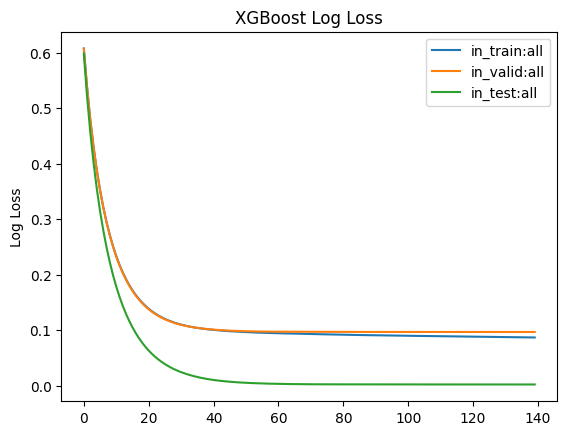

In [29]:
eval_metric = training_args['eval_metric']
epochs = len(evals_result[set_names[0]][eval_metric])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
for splitname in evals_result:
    ax.plot(x_axis, evals_result[splitname]['logloss'], label=splitname)
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

## Post-Training Evaluation

In [30]:
ds_case_final_dict

{'in_train:all': {'X': <81575x445 sparse matrix of type '<class 'numpy.float64'>'
  	with 11048447 stored elements in Compressed Sparse Row format>,
  'Y': array([0., 0., 0., ..., 0., 0., 0.])},
 'in_valid:all': {'X': <9238x445 sparse matrix of type '<class 'numpy.float64'>'
  	with 1250611 stored elements in Compressed Sparse Row format>,
  'Y': array([0., 0., 0., ..., 0., 0., 0.])},
 'in_test:all': {'X': <7949x445 sparse matrix of type '<class 'numpy.float64'>'
  	with 1077529 stored elements in Compressed Sparse Row format>,
  'Y': array([0., 0., 0., ..., 0., 0., 0.])}}

in_valid:all
Mean of Real Y Label: 0.025871400736090063 over 9238 num_sample
Accuracy (TP + TN / TP + TN + FP + FN): 0.93 over 9238 num_sample
Precision (TP / TP + FP): 0.15 over 634 postive_num
Recall (TP / TP + FN): 0.39 over 239 label1_num
F1 Score: 0.21305841924398627
ROC-AUC: 0.8435563040244825
          fpr       tpr  thresholds
0    0.000000  0.000000    1.568807
1    0.000111  0.000000    0.568807
2    0.000222  0.000000    0.544311
3    0.000222  0.004184    0.528634
4    0.000444  0.004184    0.396899
..        ...       ...         ...
762  0.983776  1.000000    0.000120
763  0.983998  1.000000    0.000120
764  0.997889  1.000000    0.000092
765  0.998111  1.000000    0.000092
766  1.000000  1.000000    0.000067

[767 rows x 3 columns]
y_pred_score_Group-0: {'y_real_label_rate': 0.0, 'y_pred_score_mean': 0.0001, 'y_pred_score_max': 0.0001, 'y_pred_score_min': 0.0001, 'group_size': 93}
y_pred_score_Group-1: {'y_real_label_rate': 0.0, 'y_pred_score_mean': 0.0001, 'y_pred_score

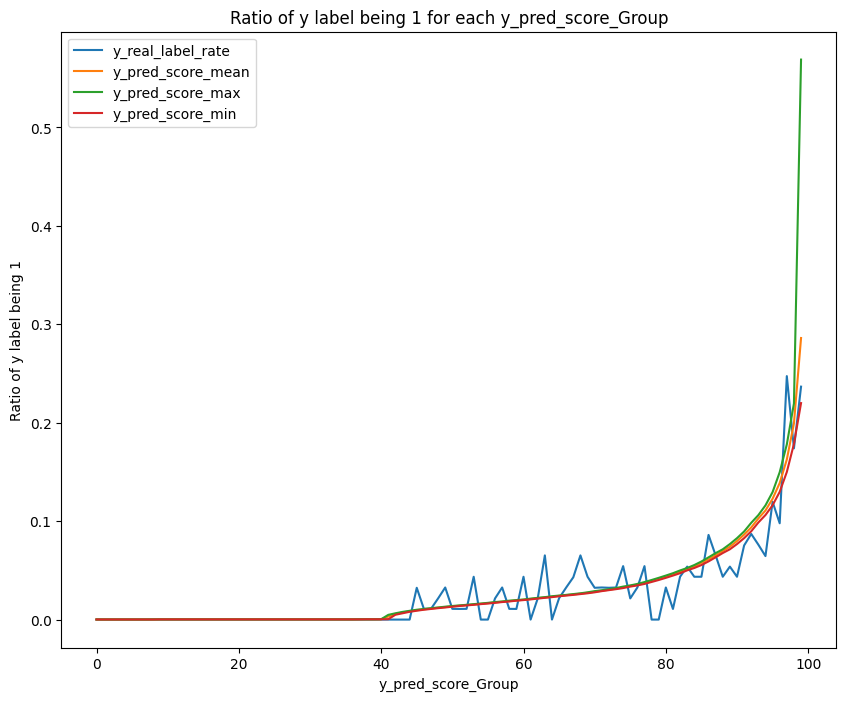

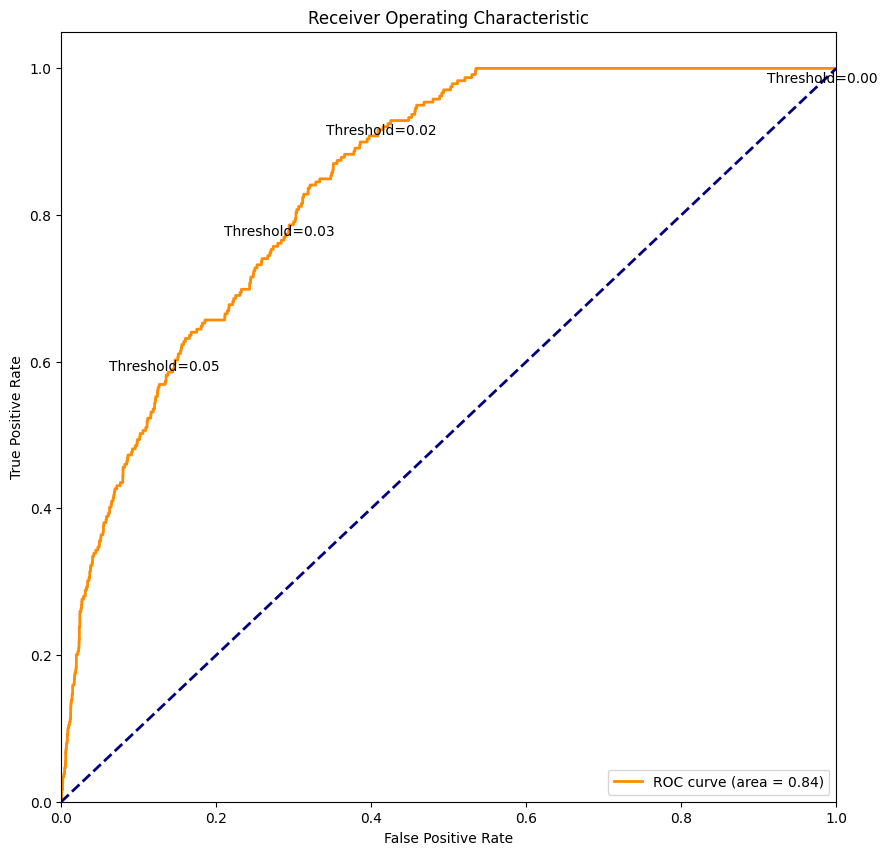

in_test:all
Mean of Real Y Label: 0.000629009938357026 over 7949 num_sample
Accuracy (TP + TN / TP + TN + FP + FN): 1.0 over 7949 num_sample
Precision (TP / TP + FP): 0.21 over 19 postive_num
Recall (TP / TP + FN): 0.8 over 5 label1_num
F1 Score: 0.3333333333333333
ROC-AUC: 0.9991188318227594
          fpr  tpr  thresholds
0    0.000000  0.0    1.388952
1    0.000000  0.2    0.388952
2    0.000126  0.2    0.343366
3    0.000126  0.4    0.288241
4    0.000252  0.4    0.252979
..        ...  ...         ...
849  0.995468  1.0    0.000090
850  0.995720  1.0    0.000090
851  0.997231  1.0    0.000086
852  0.997482  1.0    0.000085
853  1.000000  1.0    0.000056

[854 rows x 3 columns]
y_pred_score_Group-0: {'y_real_label_rate': 0.0, 'y_pred_score_mean': 0.0001, 'y_pred_score_max': 0.0001, 'y_pred_score_min': 0.0001, 'group_size': 80}
y_pred_score_Group-1: {'y_real_label_rate': 0.0, 'y_pred_score_mean': 0.0001, 'y_pred_score_max': 0.0001, 'y_pred_score_min': 0.0001, 'group_size': 79}
y_pred

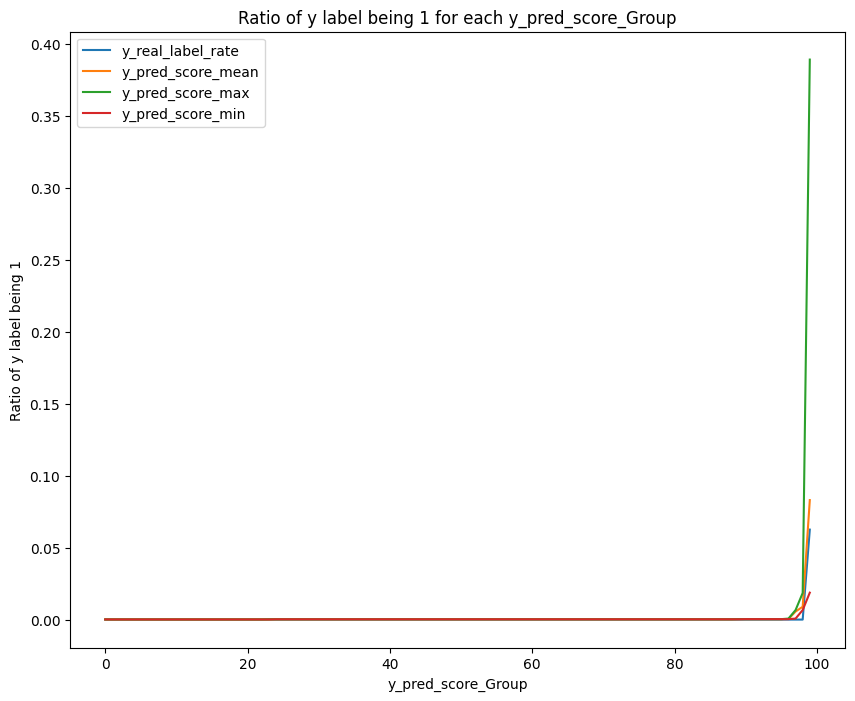

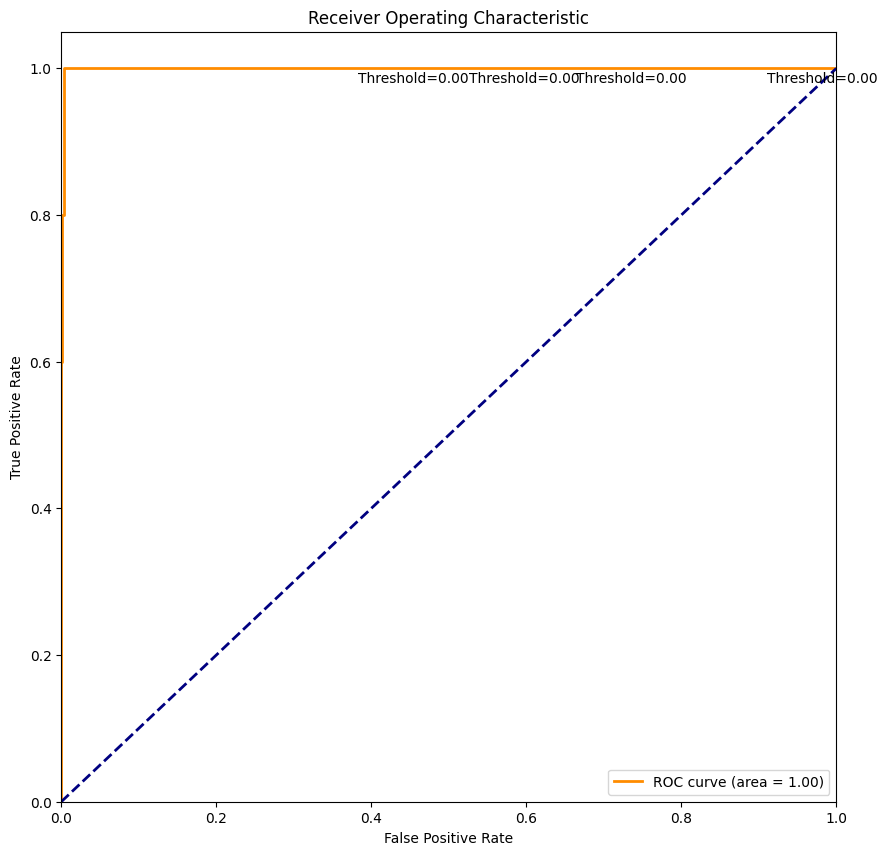

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import numpy as np 


# For binary classification, convert probabilities to binary predictions (0 or 1)
# This threshold can be adjusted based on your requirements
threshold = 0.1

for EvalSetName in EvalSetNames:
    print(EvalSetName)
    dataset = ds_case_final_dict[EvalSetName]
    X, y_real_label = dataset['X'], dataset['Y']
    
    y_real_label_mean = np.mean(y_real_label)
    if y_real_label_mean == 0: 
        print(f"Mean of Real Y: {y_real_label_mean} is 0"); continue

    y_pred_score = model.predict_proba(X)[:, 1] # 0, negative, 1, positive
    y_pred_label = [1 if score > threshold else 0 for score in y_pred_score]
    
    assert len(y_real_label) == len(y_pred_label)

    # Calculate metrics
    accuracy  = round(accuracy_score(y_real_label, y_pred_label), 2)
    precision = round(precision_score(y_real_label, y_pred_label), 2)
    recall    = round(recall_score(y_real_label, y_pred_label), 2)
    f1 = f1_score(y_real_label, y_pred_label)
    roc_auc = roc_auc_score(y_real_label, y_pred_score)
    fpr, tpr, thresholds = roc_curve(y_real_label, y_pred_score)
    roc_auc = auc(fpr, tpr)

    # Print metrics
    num_sample = len(y_pred_label)
    postive_num = (np.array(y_pred_label) == 1).sum()
    label1_num = (np.array(y_real_label) == 1).sum()
    print(f"Mean of Real Y Label: {y_real_label_mean} over {num_sample} num_sample")
    print(f"Accuracy (TP + TN / TP + TN + FP + FN): {accuracy} over {num_sample} num_sample")
    print(f"Precision (TP / TP + FP): {precision} over {postive_num} postive_num") # the choosed postive. how many are correct.
    print(f"Recall (TP / TP + FN): {recall} over {label1_num} label1_num")
    print(f"F1 Score: {f1}")
    print(f"ROC-AUC: {roc_auc}")
    
    df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
    print(df)

    # Confusion matrix
    # tn, fp, fn, tp = confusion_matrix(y_real_label, y_pred_label).ravel()

    # # TPR and FPR
    # if np.mean(y_pred_label) != 0 and np.mean(y_pred_label) != 1:
    #     tpr = tp / (tp + fn)
    #     fpr = fp / (fp + tn)
    #     print('\nthreshold:', threshold)
    #     print(f"True Positive Rate: {tpr}")
    #     print(f"False Positive Rate: {fpr}\n")

    # Create a DataFrame
    df_eval = pd.DataFrame({
        'y_real_label': y_real_label,
        'y_pred_score': y_pred_score.tolist()
    })

    # Sort the DataFrame based on the 'Predicted' column
    df_eval = df_eval.sort_values(by='y_pred_score', ascending=False) 

    # For each percentile: i% to i + 1 %, report its the ratio of that y label is 1.
    # Calculate the percentile for each row based on the 'Predicted' column
    Group_Num = 100
    df_eval['y_pred_score_Group'] = pd.qcut(df_eval['y_pred_score'], Group_Num, labels=False)

    # Calculate the ratio of y label being 1 for each percentile
    Group_to_GroupInfo = {}
    Group_Values = sorted(list(df_eval['y_pred_score_Group'].unique()))
    for group_value in Group_Values:
        df_eval_predscore_group = df_eval[df_eval['y_pred_score_Group'] == group_value]
        y_real_label_rate = np.mean(df_eval_predscore_group['y_real_label'])

        GroupInfo = {
            'y_real_label_rate': y_real_label_rate,
            'y_pred_score_mean': np.mean(df_eval_predscore_group['y_pred_score']),
            'y_pred_score_max': np.max(df_eval_predscore_group['y_pred_score']),
            'y_pred_score_min': np.min(df_eval_predscore_group['y_pred_score']),
            'group_size': len(df_eval_predscore_group),
        }
        GroupInfo = {k: round(v, 4) for k, v in GroupInfo.items()}  
        Group_to_GroupInfo[group_value] = GroupInfo
    
    # # Print the ratios for each percentile
    for group_value, GroupInfo in Group_to_GroupInfo.items():
        print(f"y_pred_score_Group-{group_value}: {GroupInfo}")

    # Plot the ratios
    plt.figure(figsize=(10, 8))
    for label in GroupInfo:
        if label == 'group_size': continue
        plt.plot(Group_to_GroupInfo.keys(), 
                 [GroupInfo[label] for GroupInfo in Group_to_GroupInfo.values()],
                 # marker='o',
                 label = label)
    plt.xlabel('y_pred_score_Group')
    plt.ylabel('Ratio of y label being 1')
    plt.title('Ratio of y label being 1 for each y_pred_score_Group')
    plt.legend()
    plt.show()


    # Plot ROC curve
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
            label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Select thresholds to annotate on the curve
    # You can choose specific thresholds that are of interest or select them based on criteria
    indices_to_annotate = [len(thresholds) // 3 * 1, len(thresholds) // 2, len(thresholds) // 3 * 2, len(thresholds) - 1]  # Example: start, middle, end
    for i in indices_to_annotate:
        plt.annotate(f'Threshold={thresholds[i]:.2f}', (fpr[i], tpr[i]),
                    textcoords="offset points", xytext=(-10,-10), ha='center')

    plt.show()


# Step 7: Save Model

In [32]:
from datetime import datetime
###############
TASK = SPACE['MODEL_TASK'].split('_')[-1]
date = datetime.now().strftime("%Y.%m.%d")
model_checkpoint_name = f'{TASK}-{date}-naive-XGBoost'
print(model_checkpoint_name)
###############

model_repo_local = '../model/model_phase1/v0.1/'


model_checkpoint_path = os.path.join(model_repo_local, model_checkpoint_name)
if not os.path.exists(model_checkpoint_path): os.makedirs(model_checkpoint_path)

EduRxPred-2024.03.03-naive-XGBoost


In [33]:
####################################
LoadFnMethod = 'LoadXGBoost'
####################################


import inspect

def save_model(model, model_checkpoint_path):
    if not os.path.exists(model_checkpoint_path): os.makedirs(model_checkpoint_path)
    model_path = os.path.join(model_checkpoint_path, 'model.xgb')
    model.save_model(model_path)

def load_model(model_checkpoint_path):
    model_path = os.path.join(model_checkpoint_path, 'model.xgb')
    import xgboost as xgb
    model = xgb.XGBClassifier()
    model.load_model(model_path)
    return model

def model_inference(model, inputs):
    X = inputs['X']
    y_pred_scores = model.predict_proba(X)[:, 1]
    # assert len(y_pred_scores) == 1
    y_pred_score = y_pred_scores[0]
    return y_pred_score

save_model.fn_string = inspect.getsource(save_model)
load_model.fn_string = inspect.getsource(load_model)
model_inference.fn_string = inspect.getsource(model_inference)
prefix = ['import pandas as pd', 'import numpy as np', 'import os']
fn_variables = [save_model, load_model, model_inference]
pycode = convert_variables_to_pystirng(fn_variables = fn_variables, prefix = prefix)
pypath = os.path.join(SPACE['CODE_FN'], 'fn_io', f'{LoadFnMethod}.py')
print(pypath)
if not os.path.exists(os.path.dirname(pypath)): os.makedirs(os.path.dirname(pypath))
with open(pypath, 'w') as file: file.write(pycode)


../pipeline/fn_io/LoadXGBoost.py


In [34]:
model_checkpoint_path

'../model/model_phase1/v0.1/EduRxPred-2024.03.03-naive-XGBoost'

In [35]:
save_model(model, model_checkpoint_path)
model = load_model(model_checkpoint_path)
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [36]:
case_args = {
    'TriggerCaseMethod': TriggerCaseMethod,
    'cohort_label_list': cohort_label_list,
    'Trigger2LearningMethods': Trigger2LearningMethods,
}
case_args

{'TriggerCaseMethod': 'TrulicityRx',
 'cohort_label_list': [1],
 'Trigger2LearningMethods': [{'op': 'Tag',
   'Name': 'TagPttBasicInfo',
   'type': 'learning-only'},
  {'op': 'Filter', 'Name': 'FilterBasicPRx', 'type': 'learning-only'}]}

In [37]:
split_args = {
    'RANDOM_SEED': RANDOM_SEED,
    'downsample_ratio': downsample_ratio,
    'out_ratio': out_ratio,
    'test_ratio': test_ratio,
    'valid_ratio': valid_ratio,
    'SplitMethod': SplitMethod,
}
split_args

{'RANDOM_SEED': 42,
 'downsample_ratio': 1,
 'out_ratio': 0,
 'test_ratio': '2023.10.15',
 'valid_ratio': 0.1,
 'SplitMethod': 'rs42-ds1-out0ts2023.10.15vd0.1'}

In [38]:
set_args = {
    'TrainSetName': TrainSetName,
    'EvalSetNames': EvalSetNames,
    'SubGroupFilterMethod': SubGroupFilterMethod,
}
set_args

{'TrainSetName': 'in_train:all',
 'EvalSetNames': ['in_valid:all', 'in_test:all'],
 'SubGroupFilterMethod': {}}

In [39]:
datapoint_args = Gamma_Configs
datapoint_args

{'InputX': {'case_observations': ['PDemo:ro.P-Demo_ct.InCaseTkn',
   'PZip3Demo:ro.P-Zip3DemoNume_ct.InCaseTkn',
   'PZip3Econ:ro.P-Zip3EconNume_ct.InCaseTkn',
   'PZip3House:ro.P-Zip3HousingNume_ct.InCaseTkn',
   'PZip3Social:ro.P-Zip3SocialNume_ct.InCaseTkn',
   'RxInCase1:ro.Rx-InObs-CmpCate_ct.InCaseTkn',
   'RxInCase2:ro.Rx-InObs-InsCate_ct.InCaseTkn',
   'RxInCase4:ro.Rx-InObs-QuantNume_ct.InCaseTkn',
   'RxInCase5:ro.Rx-InObs-ServiceCate_ct.InCaseTkn',
   'RxInCase6:ro.Rx-InObs-SysCate_ct.InCaseTkn',
   'RxInObsNum:ro.Rx-InObs_ct.RecNum'],
  'name_CaseGamma': 'InputCatCOs'},
 'OutputY': {'case_observations': ['FutEduTknY:ro.EgmEdu-Af1W_ct.FutRxEduTkn'],
  'name_CaseGamma': 'LabelBinaryRxBtn'}}

In [40]:
entry_args

{'entry_method_for_input': 'get_MLSparseMatrix_return_X',
 'entry_method_for_output': 'get_OutputBinaryLabel_return_Y',
 'entry_method_for_finaldata': 'tuple_XMatrix_and_YMatrix'}

In [41]:
set_args

{'TrainSetName': 'in_train:all',
 'EvalSetNames': ['in_valid:all', 'in_test:all'],
 'SubGroupFilterMethod': {}}

In [42]:
data_args = {
    'case_args': case_args,
    'split_args': split_args,
    'set_args': set_args,
    'datapoint_args': datapoint_args,
    'entry_args': entry_args,
}

pprint(data_args, sort_dicts=False) 

{'case_args': {'TriggerCaseMethod': 'TrulicityRx',
               'cohort_label_list': [1],
               'Trigger2LearningMethods': [{'op': 'Tag',
                                            'Name': 'TagPttBasicInfo',
                                            'type': 'learning-only'},
                                           {'op': 'Filter',
                                            'Name': 'FilterBasicPRx',
                                            'type': 'learning-only'}]},
 'split_args': {'RANDOM_SEED': 42,
                'downsample_ratio': 1,
                'out_ratio': 0,
                'test_ratio': '2023.10.15',
                'valid_ratio': 0.1,
                'SplitMethod': 'rs42-ds1-out0ts2023.10.15vd0.1'},
 'set_args': {'TrainSetName': 'in_train:all',
              'EvalSetNames': ['in_valid:all', 'in_test:all'],
              'SubGroupFilterMethod': {}},
 'datapoint_args': {'InputX': {'case_observations': ['PDemo:ro.P-Demo_ct.InCaseTkn',
                   

In [43]:
# preprocess dp to models.

In [44]:
model_args

{'algorithm': 'XGBClassifier', 'random_state': 42, 'max_depth': 5}

In [45]:
training_args

{'n_estimators': 500,
 'learning_rate': 0.1,
 'objective': 'binary:logistic',
 'early_stopping_rounds': 10,
 'eval_metric': 'logloss'}

In [46]:
io_args = {
    'model_checkpoint_name': model_checkpoint_name,
    'LoadFnMethod': LoadFnMethod,
}
io_args

{'model_checkpoint_name': 'EduRxPred-2024.03.03-naive-XGBoost',
 'LoadFnMethod': 'LoadXGBoost'}

In [47]:
from recfldtkn.pipeline_model import load_complete_PipelineInfo


use_inference = True
PipelineInfo = load_complete_PipelineInfo(datapoint_args, base_config, use_inference)
PipelineInfo

{'RecNameList': ['P', 'PInv', 'Rx'],
 'CkpdNameList': ['InObs'],
 'FldTknList': ['P-DemoTkn',
  'P-Zip3DemoNumeTkn',
  'P-Zip3EconNumeTkn',
  'P-Zip3HousingNumeTkn',
  'P-Zip3SocialNumeTkn',
  'Rx-CmpCateTkn',
  'Rx-InsCateTkn',
  'Rx-QuantNumeTkn',
  'Rx-ServiceCateTkn',
  'Rx-SysCateTkn'],
 'CasePhiList': ['InCaseTkn', 'RecNum']}

In [48]:
use_inference = False
PipelineInfo = load_complete_PipelineInfo(datapoint_args, base_config, use_inference)
PipelineInfo

{'RecNameList': ['P', 'PInv', 'Rx', 'EgmEdu'],
 'CkpdNameList': ['Af1W', 'InObs'],
 'FldTknList': ['P-DemoTkn',
  'P-Zip3DemoNumeTkn',
  'P-Zip3EconNumeTkn',
  'P-Zip3HousingNumeTkn',
  'P-Zip3SocialNumeTkn',
  'Rx-CmpCateTkn',
  'Rx-InsCateTkn',
  'Rx-QuantNumeTkn',
  'Rx-ServiceCateTkn',
  'Rx-SysCateTkn'],
 'CasePhiList': ['FutRxEduTkn', 'InCaseTkn', 'RecNum']}

In [49]:
SPACE

{'DATA_RAW': '../_Data/0-Data_Raw',
 'DATA_RFT': '../_Data/1-Data_RFT',
 'DATA_EXTERNAL': '../external',
 'DATA_CaseObs': '../_Data/2-Data_CaseObs',
 'DATA_CaseFeat': '../_Data/3-Data_CaseFeat',
 'DATA_CaseSet': '../_Data/4-Data_CaseSet',
 'CODE_FN': '../pipeline',
 'CODE_RFT': '../pipeline',
 'DATA_TASK': 'Data_EduRxPred',
 'MODEL_TASK': 'Model_EduRxPred',
 'TaskName': 'EduRxPred',
 'WORKSPACE_PATH': '/Users/floydluo/Library/CloudStorage/OneDrive-DRFIRST.COM,INC/Documents - DrFirst-JHU Collaboration Center/DrFirst-Project/2024-DrFirst-v2-SPACE/_DrFirst-AI-EduRxPred-WorkSpace'}

In [50]:

New_SPACE = {
    # 'WORKSPACE_PATH': WORKSPACE_PATH, 
    'DATA_EXTERNAL': f'external',
    'CODE_FN': f'pipeline', 
    'CODE_RFT': f'pipeline',
    'DATA_RAW': None ,
    'DATA_RFT': None,
    'DATA_CaseObs': None,
    'DATA_CaseFeat': None,
    'DATA_CaseSet': None,
    'DATA_TASK': None,
    'MODEL_TASK': None, 
    'TaskName': None,
}

In [51]:
checkpoint_args = {
    'data_args': data_args,
    'model_args': model_args,
    'training_args': training_args,
    'io_args': io_args,
    'SPACE': New_SPACE,
}

In [52]:
import json
import shutil
# checkpioint_args

#### model
model_path = os.path.join(model_checkpoint_path, 'model.xgb')
LoadFnMethod = LoadFnMethod

#### checkpoint_args_path
path = os.path.join(model_checkpoint_path, 'checkpoint_args.json')
with open(path, 'w') as f:
    json.dump(checkpoint_args, f, indent=4)


#### CFType_to_CFVocab
CFType_to_CFVocab = {k: v['CF_vocab'] for k, v in CFType_to_CaseFeatInfo.items()}
path = os.path.join(model_checkpoint_path, 'CFType_to_CFVocab.json')
with open(path, 'w') as f:
    json.dump(CFType_to_CFVocab, f, indent=4)


#### pipeline 
pipeline_folder = os.path.join(model_checkpoint_path, 'pipeline')
if os.path.exists(pipeline_folder):
    shutil.rmtree(pipeline_folder)
shutil.copytree(SPACE['CODE_FN'], pipeline_folder)
print(pipeline_folder)


#### external 
external_folder = os.path.join(model_checkpoint_path, 'external')
if os.path.exists(external_folder):
    shutil.rmtree(external_folder)
shutil.copytree(SPACE['DATA_EXTERNAL'], external_folder)
print(external_folder)

../model/model_phase1/v0.1/EduRxPred-2024.03.03-naive-XGBoost/pipeline
../model/model_phase1/v0.1/EduRxPred-2024.03.03-naive-XGBoost/external
